In [1]:
import numpy as np
 
 
def siam_hamiltonian(
    norb: int,
    hopping: float,
    onsite: float,
    hybridization: float,
    chemical_potential: float,
) -> tuple[np.ndarray, np.ndarray]:
    """Hamiltonian for the single-impurity Anderson model."""
    # Place the impurity on the first site
    impurity_orb = 0
 
    # One body matrix elements in the "position" basis
    h1e = np.zeros((norb, norb))
    np.fill_diagonal(h1e[:, 1:], -hopping)
    np.fill_diagonal(h1e[1:, :], -hopping)
    h1e[impurity_orb, impurity_orb + 1] = -hybridization
    h1e[impurity_orb + 1, impurity_orb] = -hybridization
    h1e[impurity_orb, impurity_orb] = chemical_potential
 
    # Two body matrix elements in the "position" basis
    h2e = np.zeros((norb, norb, norb, norb))
    h2e[impurity_orb, impurity_orb, impurity_orb, impurity_orb] = onsite
 
    return h1e, h2e
 
 
def momentum_basis(norb: int) -> np.ndarray:
    """Get the orbital rotation to change from the position to the momentum basis."""
    n_bath = norb - 1
 
    # Orbital rotation that diagonalizes the bath (non-interacting system)
    hopping_matrix = np.zeros((n_bath, n_bath))
    np.fill_diagonal(hopping_matrix[:, 1:], -1)
    np.fill_diagonal(hopping_matrix[1:, :], -1)
    _, vecs = np.linalg.eigh(hopping_matrix)
 
    # Expand to include impurity
    orbital_rotation = np.zeros((norb, norb))
    # Impurity is on the first site
    orbital_rotation[0, 0] = 1
    orbital_rotation[1:, 1:] = vecs
 
    # Move the impurity to the center
    new_index = n_bath // 2
    perm = np.r_[1 : (new_index + 1), 0, (new_index + 1) : norb]
    orbital_rotation = orbital_rotation[:, perm]
 
    return orbital_rotation
 
 
def rotated(
    h1e: np.ndarray, h2e: np.ndarray, orbital_rotation: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Rotate the orbital basis of a Hamiltonian."""
    h1e_rotated = np.einsum(
        "ab,Aa,Bb->AB",
        h1e,
        orbital_rotation,
        orbital_rotation.conj(),
        optimize="greedy",
    )
    h2e_rotated = np.einsum(
        "abcd,Aa,Bb,Cc,Dd->ABCD",
        h2e,
        orbital_rotation,
        orbital_rotation.conj(),
        orbital_rotation,
        orbital_rotation.conj(),
        optimize="greedy",
    )
    return h1e_rotated, h2e_rotated
 
 
# Total number of spatial orbitals, including the bath sites and the impurity
# This should be an even number
norb = 20
 
# System is half-filled
nelec = (norb // 2, norb // 2)
# One orbital is the impurity, the rest are bath sites
n_bath = norb - 1
 
# Hamiltonian parameters
hybridization = 1.0
hopping = 1.0
onsite = 10.0
chemical_potential = -0.5 * onsite
 
# Generate Hamiltonian in position basis
h1e, h2e = siam_hamiltonian(
    norb=norb,
    hopping=hopping,
    onsite=onsite,
    hybridization=hybridization,
    chemical_potential=chemical_potential,
)
 
# Rotate to momentum basis
orbital_rotation = momentum_basis(norb)
h1e_momentum, h2e_momentum = rotated(h1e, h2e, orbital_rotation.T.conj())
# In the momentum basis, the impurity is placed in the center
impurity_index = n_bath // 2

/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: divide by zero encountered in dot
  res = dot(at, bt)
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: overflow encountered in dot
  res = dot(at, bt)
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)


In [2]:
from typing import Sequence
 
import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import CircuitInstruction, Qubit
from qiskit.circuit.library import CPhaseGate, XGate, XXPlusYYGate
 
 
def prepare_initial_state(qubits: Sequence[Qubit], norb: int, nocc: int):
    """Prepare initial state."""
    x_gate = XGate()
    rot = XXPlusYYGate(0.5 * np.pi, -0.5 * np.pi)
    for i in range(nocc):
        yield CircuitInstruction(x_gate, [qubits[i]])
        yield CircuitInstruction(x_gate, [qubits[norb + i]])
    for i in range(3):
        for j in range(nocc - i - 1, nocc + i, 2):
            yield CircuitInstruction(rot, [qubits[j], qubits[j + 1]])
            yield CircuitInstruction(
                rot, [qubits[norb + j], qubits[norb + j + 1]]
            )
    yield CircuitInstruction(rot, [qubits[j + 1], qubits[j + 2]])
    yield CircuitInstruction(
        rot, [qubits[norb + j + 1], qubits[norb + j + 2]]
    )
 
 
def trotter_step(
    qubits: Sequence[Qubit],
    time_step: float,
    one_body_evolution: np.ndarray,
    h2e: np.ndarray,
    impurity_index: int,
    norb: int,
):
    """A Trotter step."""
    # Assume the two-body interaction is just the on-site interaction of the impurity
    onsite = h2e[
        impurity_index, impurity_index, impurity_index, impurity_index
    ]
    # Two-body evolution for half the time
    yield CircuitInstruction(
        CPhaseGate(-0.5 * time_step * onsite),
        [qubits[impurity_index], qubits[norb + impurity_index]],
    )
    # One-body evolution for the full time
    yield CircuitInstruction(
        ffsim.qiskit.OrbitalRotationJW(norb, one_body_evolution), qubits
    )
    # Two-body evolution for half the time
    yield CircuitInstruction(
        CPhaseGate(-0.5 * time_step * onsite),
        [qubits[impurity_index], qubits[norb + impurity_index]],
    )
 
 
# Time step
time_step = 0.2
# Number of Krylov basis states
krylov_dim = 8
 
# Initialize circuit
qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)
 
# Generate initial state
for instruction in prepare_initial_state(qubits, norb=norb, nocc=norb // 2):
    circuit.append(instruction)
circuit.measure_all()
 
# Create list of circuits, starting with the initial state circuit
circuits = [circuit.copy()]
 
# Add time evolution circuits to the list
one_body_evolution = scipy.linalg.expm(-1j * time_step * h1e_momentum)
for i in range(krylov_dim - 1):
    # Remove measurements
    circuit.remove_final_measurements()
    # Append another Trotter step
    for instruction in trotter_step(
        qubits,
        time_step,
        one_body_evolution,
        h2e_momentum,
        impurity_index,
        norb,
    ):
        circuit.append(instruction)
    # Measure qubits
    circuit.measure_all()
    # Add a copy of the circuit to the list
    circuits.append(circuit.copy())

/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: divide by zero encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: overflow encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/ffsim/linalg/predicates.py:85: RuntimeWarning: invalid value encountered in matmul
  return m == n and np.allclose(mat @ mat.T.conj(), np.eye(m), rtol=rtol, atol=atol)


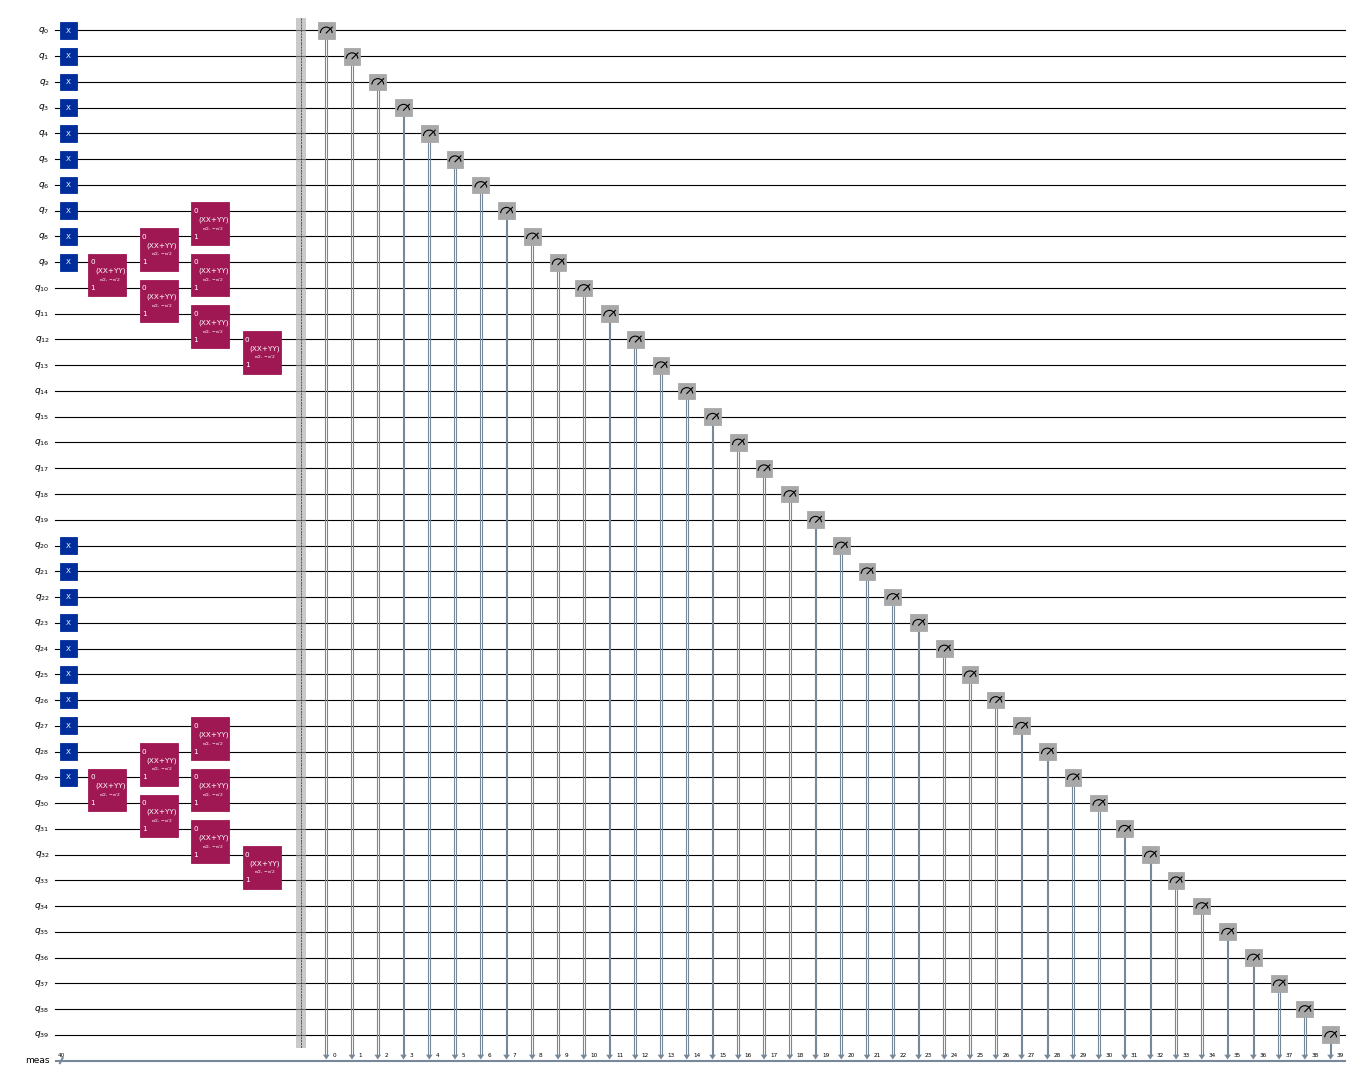

In [4]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

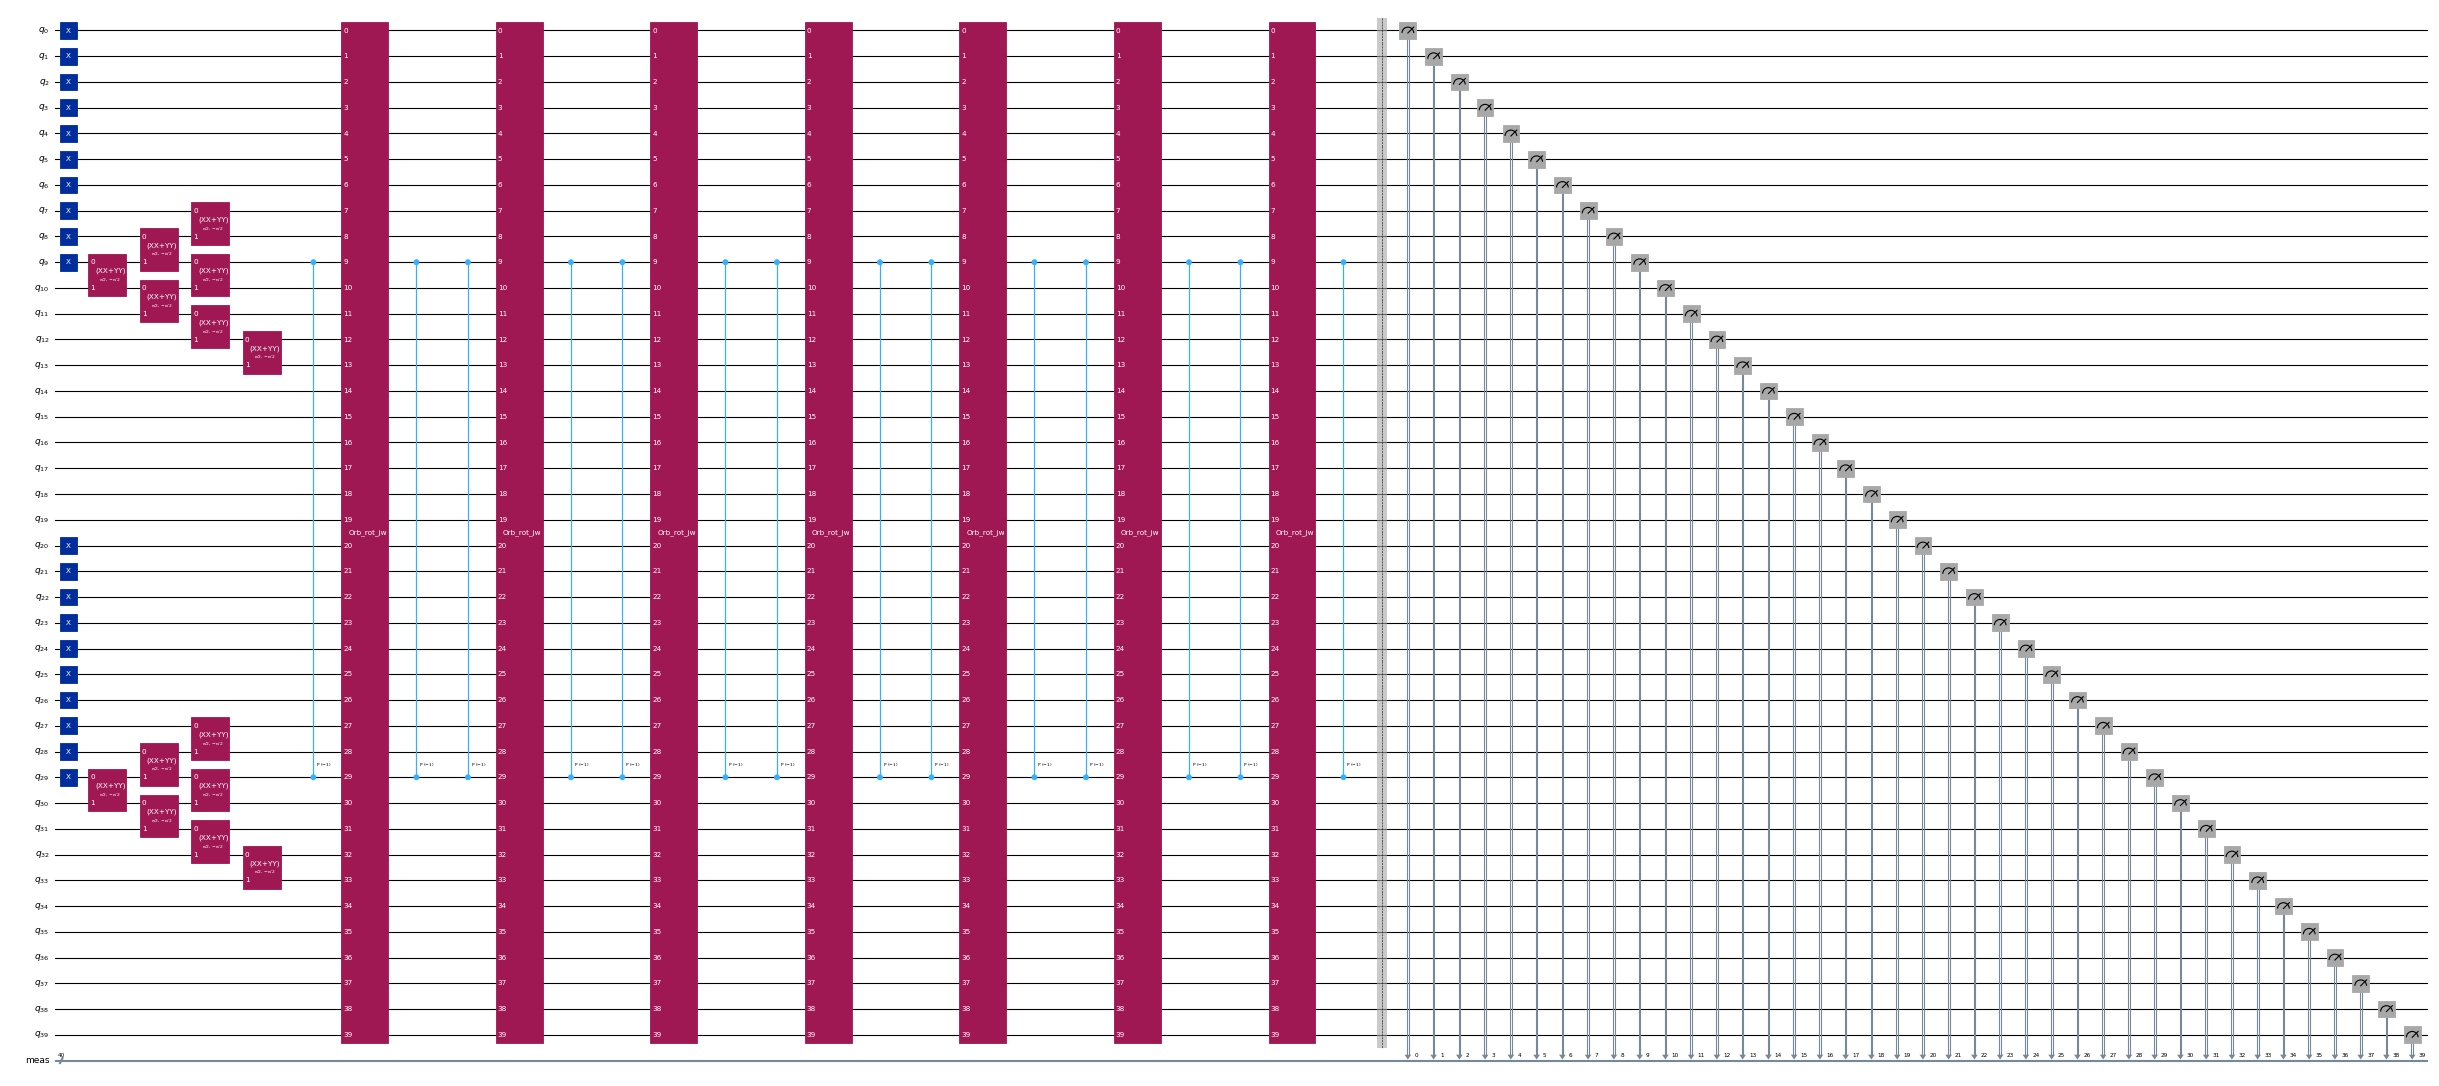

In [5]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(f"Using backend {backend.name}")

qiskit_runtime_service.__init__:WARNING:2026-02-07 16:48:59,552: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: qiskit_small_codes. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-07 16:49:00,700: Loading instance: qiskit_small_codes, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-07 16:49:02,741: Using instance: qiskit_small_codes, plan: open


Using backend ibm_fez


In [7]:
from qiskit.transpiler import generate_preset_pass_manager
 
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)
isa_circuits = pass_manager.run(circuits)

In [8]:
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# Sample from the circuits
sampler = Sampler(backend)
job = sampler.run(isa_circuits, shots=500)

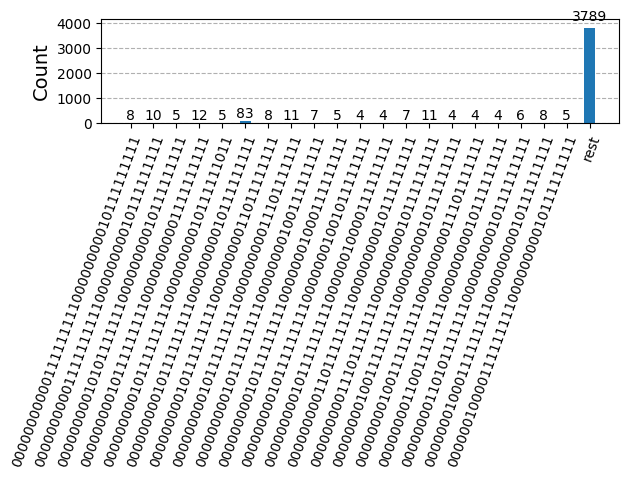

In [9]:
from qiskit.primitives import BitArray
 
# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots(
    [result.data.meas for result in job.result()]
)
 
plot_histogram(bit_array.get_counts(), number_to_keep=20)

In [11]:
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
)
 
# List to capture intermediate results
result_history = []
 
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
 
rng = np.random.default_rng(24)
result = diagonalize_fermionic_hamiltonian(
    h1e_momentum,
    h2e_momentum,
    bit_array,
    samples_per_batch=100,
    norb=norb,
    nelec=nelec,
    num_batches=3,
    max_iterations=5,
    symmetrize_spin=True,
    callback=callback,
    seed=rng,
)

/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:1426: RuntimeWarning: divide by zero encountered in dot
  innerprod = dot(xi.conj(), xi).real
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:1426: RuntimeWarning: overflow encountered in dot
  innerprod = dot(xi.conj(), xi).real
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:1426: RuntimeWarning: invalid value encountered in dot
  innerprod = dot(xi.conj(), xi).real
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:173: RuntimeWarning: divide by zero encountered in dot
  heff[i,i] = dot(xt[ip].conj(), axt[ip]).real
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:173: RuntimeWarning: overflow encountered in dot
  heff[i,i] = dot(xt[ip].conj(), axt[ip]).real
/opt/anaconda3/envs/ibm/lib/python3.14/site-packages/pyscf/lib/linalg_helper.py:173: RuntimeWarning: invalid value encountered 

Iteration 1
	Subsample 0
		Energy: -28.623560855307254
		Subspace dimension: 12321
	Subsample 1
		Energy: -28.622503314991267
		Subspace dimension: 12769
	Subsample 2
		Energy: -28.613570827541487
		Subspace dimension: 11881
Iteration 2
	Subsample 0
		Energy: -28.64904336075419
		Subspace dimension: 37249
	Subsample 1
		Energy: -28.655638529504202
		Subspace dimension: 40000
	Subsample 2
		Energy: -28.646018025654048
		Subspace dimension: 35344
Iteration 3
	Subsample 0
		Energy: -28.657584411651914
		Subspace dimension: 39601
	Subsample 1
		Energy: -28.688920496585975
		Subspace dimension: 42025
	Subsample 2
		Energy: -28.68937631588211
		Subspace dimension: 40401
Iteration 4
	Subsample 0
		Energy: -28.694006982336337
		Subspace dimension: 45369
	Subsample 1
		Energy: -28.68971093035093
		Subspace dimension: 51076
	Subsample 2
		Energy: -28.689559161742668
		Subspace dimension: 53361
Iteration 5
	Subsample 0
		Energy: -28.700103463807228
		Subspace dimension: 53361
	Subsample 1
		Energ

Reference (DMRG) energy: -28.70660
SQD energy: -28.70010
Absolute error: 0.00649


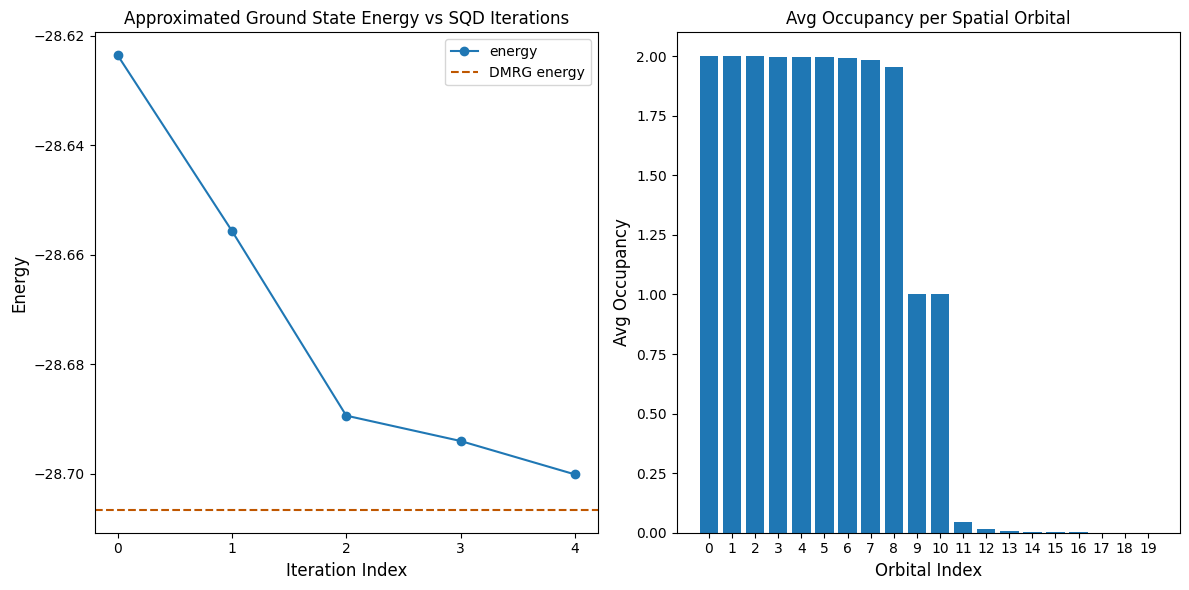

In [12]:
import matplotlib.pyplot as plt
 
dmrg_energy = -28.70659686
 
min_es = [
    min(result, key=lambda res: res.energy).energy
    for result in result_history
]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])
 
# Data for energies plot
x1 = range(len(result_history))
 
# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, min_es, label="energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].axhline(
    y=dmrg_energy, color="#BF5700", linestyle="--", label="DMRG energy"
)
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
print(f"Reference (DMRG) energy: {dmrg_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - dmrg_energy):.5f}")
plt.tight_layout()
plt.show()

In [13]:
rdm1 = result.sci_state.rdm(rank=1, spin_summed=True)
rdm2 = result.sci_state.rdm(rank=2, spin_summed=True)
 
energy = np.sum(h1e_momentum * rdm1) + 0.5 * np.sum(h2e_momentum * rdm2)
 
print(f"Recomputed energy: {energy:.5f}")

Recomputed energy: -28.70010
